#### Imports and environment creation

In [30]:
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
from minigrid.core.constants import IDX_TO_OBJECT, OBJECT_TO_IDX
import gymnasium as gym

from minigrid.core.actions import Actions
from dataclasses import dataclass, field 
from typing import Set
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn, optim

In [2]:
#Choose grid width/height (the grid is a square)
WORLD_N=8
WORLD_N_SQ = WORLD_N**2

#Choose the gym environment 
env = gym.make(f"MiniGrid-Empty-{WORLD_N}x{WORLD_N}-v0", render_mode="rgb_array")
#env = gym.make(f"MiniGrid-Dynamic-Obstacles-{WORLD_N}x{WORLD_N}-v0", render_mode="rgb_array")

env.valid_actions = {Actions.left, Actions.right, Actions.forward}

def get_array_repr(env):
    grid_array = env.unwrapped.grid.encode()[:,:,0]
    grid_array[env.agent_pos[0],env.agent_pos[1]]=OBJECT_TO_IDX['agent']
    return grid_array.T

env.reset()
print(get_array_repr(env))

map_numbers = range(1,11)


[[ 2  2  2  2  2  2  2  2]
 [ 2 10  1  1  1  1  1  2]
 [ 2  1  1  1  1  1  1  2]
 [ 2  1  1  1  1  1  1  2]
 [ 2  1  1  1  1  1  1  2]
 [ 2  1  1  1  1  1  1  2]
 [ 2  1  1  1  1  1  8  2]
 [ 2  2  2  2  2  2  2  2]]


/mnt/c/Users/tiago/Desktop/Code/SURFiN/mg10/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_pos` for environment variables or `env.get_wrapper_attr('agent_pos')` that will search the reminding wrappers.
  logger.warn(


<class 'gymnasium.wrappers.order_enforcing.OrderEnforcing'>


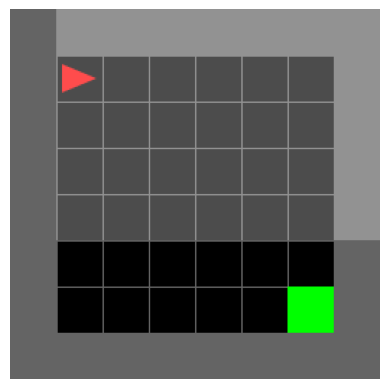

In [3]:
#Render the map
print(type(env))
env_core = env.unwrapped
plt.axis('off')
plt.imshow(env_core.render())

#### Agent motion

In [4]:
from agents.random import RandomAgent
n_steps_train = 8000
n_steps_test = 2000

random_action_agent = RandomAgent(valid_actions=env.valid_actions)

dirarr = ['Right', 'Down', 'Left','Up']
actions_to_idx = {Actions.left:0, Actions.right:1, Actions.forward:2}

image_list_train = []

for i in range(n_steps_train):
    action = random_action_agent.act()
    arr = get_array_repr(env).flatten()
    if (actions_to_idx[action] == 2):
        arr = np.append(arr, env.agent_dir)
    else:
        arr = np.append(arr, 4)    
    image_list_train.append(arr)
    env.step(action)

env.reset()
image_list_test = []

for i in range(n_steps_test):
    action = random_action_agent.act()
    arr = get_array_repr(env).flatten()
    if (actions_to_idx[action] == 2):
        arr = np.append(arr, env.agent_dir)
    else:
        arr = np.append(arr, 4)    
    image_list_test.append(arr)
    env.step(action)

print(image_list_train[:3])

/mnt/c/Users/tiago/Desktop/Code/SURFiN/mg10/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_dir to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_dir` for environment variables or `env.get_wrapper_attr('agent_dir')` that will search the reminding wrappers.
  logger.warn(


[array([ 2,  2,  2,  2,  2,  2,  2,  2,  2, 10,  1,  1,  1,  1,  1,  2,  2,
        1,  1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,  1,
        1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,  1,  1,
        1,  1,  1,  8,  2,  2,  2,  2,  2,  2,  2,  2,  2,  4]), array([ 2,  2,  2,  2,  2,  2,  2,  2,  2, 10,  1,  1,  1,  1,  1,  2,  2,
        1,  1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,  1,
        1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,  1,  1,
        1,  1,  1,  8,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1]), array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,
       10,  1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,  1,
        1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,  1,  1,
        1,  1,  1,  8,  2,  2,  2,  2,  2,  2,  2,  2,  2,  4])]


In [5]:
print(image_list_train[:3])
print(image_list_test[:3])

[array([ 2,  2,  2,  2,  2,  2,  2,  2,  2, 10,  1,  1,  1,  1,  1,  2,  2,
        1,  1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,  1,
        1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,  1,  1,
        1,  1,  1,  8,  2,  2,  2,  2,  2,  2,  2,  2,  2,  4]), array([ 2,  2,  2,  2,  2,  2,  2,  2,  2, 10,  1,  1,  1,  1,  1,  2,  2,
        1,  1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,  1,
        1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,  1,  1,
        1,  1,  1,  8,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1]), array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,
       10,  1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,  1,
        1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  1,  2,  2,  1,  1,
        1,  1,  1,  8,  2,  2,  2,  2,  2,  2,  2,  2,  2,  4])]
[array([ 2,  2,  2,  2,  2,  2,  2,  2,  2, 10,  1,  1,  1,  1,  1,  2,  2,
        1,  1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1

#### Helper functions

In [6]:
print(torch.__version__)
print(torch.cuda.is_available())  # This should return True if CUDA is available
print(torch.cuda.current_device())  # Shows the current GPU device id (e.g., 0)
print(torch.cuda.get_device_name(0))  # Displays the GPU name
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')
print(f"Using device: {device}")

2.1.1+cu121
True
0
NVIDIA GeForce MX330
Using device: cuda


In [43]:
#(Modified) Neuromatch helper funcitons
def init_weights_kaiming_normal(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming normal distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming normal distribution
    nn.init.kaiming_normal_(layer.weight.data)
    

def runSGD(net, input_train, target_train, input_test, target_test, criterion='mse',
           n_epochs=10, batch_size=32, verbose=False):
  """
  Trains autoencoder network with stochastic gradient descent with Adam
  optimizer and loss criterion. Train samples are shuffled, and loss is
  displayed at the end of each opoch for both MSE and BCE. Plots training loss
  at each minibatch (maximum of 500 randomly selected values).

  Args:
    net (torch network)
        ANN object (nn.Module)

    input_train (torch.Tensor)
        vectorized input images from train set

    input_test (torch.Tensor)
        vectorized input images from test set

    criterion (string)
        train loss: 'bce' or 'mse'

    n_epochs (boolean)
        number of full iterations of training data

    batch_size (integer)
        number of element in mini-batches

    verbose (boolean)
        print final loss

  Returns:
    Nothing.
  """

  # 1. Define the device
  # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  device = torch.device('cuda')
  print(f"Using device: {device}")

  # 2. Move the network to the device
  net.to(device)

  # 3. Move the main tensors to the device (crucial for initial setup)
  input_train = input_train.to(device)
  target_train = target_train.to(device)
  input_test = input_test.to(device)
  target_test = target_test.to(device)

  # Initialize loss function
  if criterion == 'mse':
    loss_fn = nn.MSELoss()
  elif criterion == 'bce':
    loss_fn = nn.BCELoss()
  elif criterion == 'cel':
    loss_fn = nn.CrossEntropyLoss() 
  else:
    print('Please specify either "mse" or "bce" for loss criterion')

  # Move the loss function to the device if it has parameters (CrossEntropyLoss does not, 
  # but it's good practice for others like L1Loss which might have reduction='none')
  loss_fn.to(device)

  # Initialize SGD optimizer
  optimizer = optim.Adam(net.parameters())

  # Placeholder for loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):

    
    shuffle_idx = np.random.permutation(len(input_train))

    batches_input = torch.split(input_train[shuffle_idx], batch_size)
    batches_target = torch.split(target_train[shuffle_idx], batch_size)

    batches = zip(batches_input, batches_target)


    shuffle_idx = np.random.permutation(len(input_train))
   
    for batch_input, batch_target in batches:
      batch_input = batch_input.float()
      batch_target = batch_target.float()
      output_train = net(batch_input)  # Forward pass on the input batch
      loss = loss_fn(output_train, batch_target)  # Compare output with the target
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Keep track of loss at each epoch
      track_loss += [float(loss)]

    loss_epoch = f'{i+1}/{n_epochs}'
    with torch.no_grad():
      output_train = net(input_train)
      loss_train = loss_fn(output_train, target_train)
      loss_epoch += f'\t {loss_train:.4f}'

      output_test = net(input_test)
      loss_test = loss_fn(output_test, target_test)
      loss_epoch += f'\t\t {loss_test:.4f}'

    print(loss_epoch)

  if verbose:
    # Print loss
    loss_mse = f'\nMSE\t {eval_mse(output_train, target_train):0.4f}'
    loss_mse += f'\t\t {eval_mse(output_test, target_test):0.4f}'
    print(loss_mse)

    loss_bce = f'BCE\t {eval_bce(output_train, target_train):0.4f}'
    loss_bce += f'\t\t {eval_bce(output_test, target_test):0.4f}'
    print(loss_bce)

  # Plot loss
  step = int(np.ceil(len(track_loss) / 500))
  x_range = np.arange(0, len(track_loss), step)
  plt.figure()
  plt.plot(x_range, track_loss[::step], 'C0')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.show()
  return track_loss


#### Input preparation

In [8]:
# test_size=0.2
# cutoff = int((1-test_size)*len(image_list))
X_train, X_test = image_list_train, image_list_test 

target_train = X_train[1:]
input_train = X_train[:-1]
target_test = X_test[1:]
input_test = X_test[:-1]

target_train = torch.tensor(target_train, dtype=torch.int64)
input_train = torch.tensor(input_train, dtype=torch.int64)
target_test = torch.tensor(target_test, dtype=torch.int64)
input_test = torch.tensor(input_test, dtype=torch.int64)

def normalise(a,classes):
    
    output = []
    maxi = max(classes)
    mini = min(classes)
    for i in a:
        output.append((i-mini)/(maxi-mini))
    
    return output

#One-hot encoding of discrete integer variable in range [0, num_classes)
def one_hot_encode(values, num_classes):
    one_hot = torch.zeros(num_classes)
    one_hot[values] = 1
    return one_hot

# Function to process the entire array (each input array of shape [length])
def process_input(input_array, mode):
    if mode == 'in':
    
        world_map = torch.tensor(normalise(input_array[:-1], map_numbers))
        
        action_encoding = one_hot_encode(input_array[WORLD_N_SQ], 5)
        
        return torch.cat([world_map, action_encoding], dim=0)
    elif mode == 'out':
        return torch.tensor(normalise(input_array[:-1], map_numbers))

# Apply to the whole dataset
input_train_processed = torch.stack([process_input(x, 'in') for x in input_train])
input_test_processed = torch.stack([process_input(x, 'in') for x in input_test])
target_train_processed = torch.stack([process_input(x, 'out') for x in target_train])
target_test_processed = torch.stack([process_input(x, 'out') for x in target_test])

print(target_train_processed)
print(input_train_processed)


/tmp/ipykernel_2846/1943850101.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  target_train = torch.tensor(target_train, dtype=torch.int64)


tensor([[0.1111, 0.1111, 0.1111,  ..., 0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111,  ..., 0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111,  ..., 0.1111, 0.1111, 0.1111],
        ...,
        [0.1111, 0.1111, 0.1111,  ..., 0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111,  ..., 0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111,  ..., 0.1111, 0.1111, 0.1111]])
tensor([[0.1111, 0.1111, 0.1111,  ..., 0.0000, 0.0000, 1.0000],
        [0.1111, 0.1111, 0.1111,  ..., 0.0000, 0.0000, 0.0000],
        [0.1111, 0.1111, 0.1111,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.1111, 0.1111, 0.1111,  ..., 0.0000, 0.0000, 1.0000],
        [0.1111, 0.1111, 0.1111,  ..., 0.0000, 0.0000, 1.0000],
        [0.1111, 0.1111, 0.1111,  ..., 0.0000, 0.0000, 1.0000]])


#### Autoencoder definition

In [33]:
# RNN Module

class RNNOutOnly(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.rnn = nn.RNN(*args, **kwargs)
    def forward(self, x):
        out, _ = self.rnn(x)
        return out

In [42]:
encoding_size=50
hidden_fac=15
input_size=input_train_processed.size(1)
output_size = target_train_processed.size(1)
model = nn.Sequential(
    nn.Linear(input_size, int(input_size * hidden_fac)),
    nn.ReLU(),
    nn.Linear(int(input_size * hidden_fac), encoding_size),
    nn.ReLU(),
    RNNOutOnly(encoding_size, encoding_size,nonlinearity='relu'),
    nn.Linear(encoding_size, int(output_size * hidden_fac)),
    nn.ReLU(),
    nn.Linear(int(output_size *hidden_fac), output_size),
    )

# model[:-2].apply(init_weights_kaiming_normal)

n_e = 4
n_d = 3
encoder = model[:n_e]
latent = model[n_e:-n_d]
decoder = model[-n_d:]
print(f'Encoder \n\n {encoder}\n')
print(f'Latent \n\n {latent}\n')
print(f'Decoder \n\n {decoder}')

Encoder 

 Sequential(
  (0): Linear(in_features=69, out_features=1035, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1035, out_features=50, bias=True)
  (3): ReLU()
)

Latent 

 Sequential(
  (4): RNNOutOnly(
    (rnn): RNN(50, 50)
  )
)

Decoder 

 Sequential(
  (5): Linear(in_features=50, out_features=960, bias=True)
  (6): ReLU()
  (7): Linear(in_features=960, out_features=64, bias=True)
)


#### Autoencoder training

Using device: cuda
Epoch 	 Loss train 	 Loss test
1/20	 0.0138		 0.0140
2/20	 0.0095		 0.0102
3/20	 0.0059		 0.0066
4/20	 0.0034		 0.0040
5/20	 0.0017		 0.0021
6/20	 0.0007		 0.0009
7/20	 0.0003		 0.0004
8/20	 0.0002		 0.0002
9/20	 0.0001		 0.0001
10/20	 0.0001		 0.0001
11/20	 0.0000		 0.0001
12/20	 0.0000		 0.0000
13/20	 0.0000		 0.0000
14/20	 0.0000		 0.0000
15/20	 0.0000		 0.0000
16/20	 0.0000		 0.0000
17/20	 0.0000		 0.0000
18/20	 0.0000		 0.0000
19/20	 0.0000		 0.0000
20/20	 0.0000		 0.0000


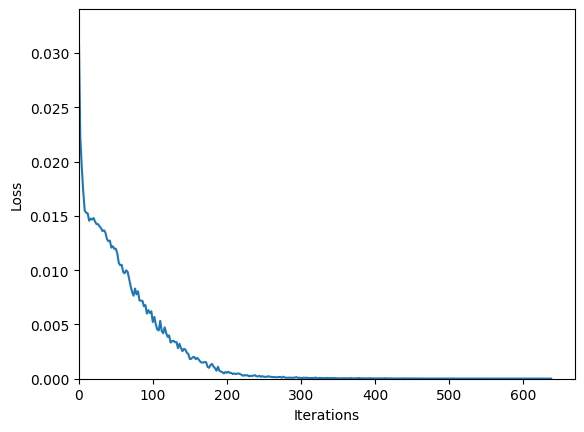

In [44]:
n_epochs = 20
batch_size = 256

tracked_losses = runSGD(model, input_train_processed, target_train_processed, input_test_processed, target_test_processed, n_epochs=n_epochs, batch_size=batch_size)

In [27]:
print(tracked_losses)

[0.03131341189146042, 0.02548695169389248, 0.022034548223018646, 0.01974056102335453, 0.01854782924056053, 0.017837155610322952, 0.016658343374729156, 0.015638679265975952, 0.014877630397677422, 0.014624116942286491, 0.015222861431539059, 0.014757773838937283, 0.015060918405652046, 0.014599956572055817, 0.01453319564461708, 0.014407827518880367, 0.014124194160103798, 0.014095867983996868, 0.013803021050989628, 0.013591654598712921, 0.013882734812796116, 0.013658741489052773, 0.013568233698606491, 0.013469232246279716, 0.01289062574505806, 0.012879153713583946, 0.012532925233244896, 0.012395554222166538, 0.012435254640877247, 0.012252986431121826, 0.011868538334965706, 0.011615089140832424, 0.011464769020676613, 0.011149019002914429, 0.010679887607693672, 0.010560911148786545, 0.010384926572442055, 0.010234883055090904, 0.010583892464637756, 0.009865418076515198, 0.009869523346424103, 0.009141385555267334, 0.008967367932200432, 0.008946471847593784, 0.009046055376529694, 0.0082114608958

#### Metrics

In [45]:
input_test_processed = input_test_processed.to(device)
output = model(input_test_processed)  # Model output (logits or probabilities)
output = output.cpu() 

# Initialize a list to hold the decoded outputs for each observation
decoded_outputs = []

incorrect_agent_num=0
incorrect_agent_location=0
incorrect_cell=0
not_perfect=0

for i in range(output.size(0)):  # Loop over each sample in the batch
    # Extract the blocks of the output
    decoded_map = output[i]
    resized_decoded_map = decoded_map*(max(map_numbers)-min(map_numbers))+min(map_numbers)
    rounded_decoded_map = torch.round(resized_decoded_map).long()
    
    num_agents = 0
    maybe_perfect=1

    for j, val in enumerate(rounded_decoded_map):
        if val== 10:
            num_agents +=1
            if (target_test[i, j] != 10):
                incorrect_agent_location=1
        if (target_test[i, j] != val):
            # print("cell", i)
            maybe_perfect=0
            incorrect_cell +=1

    if num_agents != 1:
        decoded_second = torch.tensor(-1, dtype=torch.long)
        maybe_perfect=0
        incorrect_agent_num +=1

    if not maybe_perfect:
        not_perfect +=1

    # Use torch.masked_select to get all matching values
    matches = torch.masked_select(rounded_decoded_map, rounded_decoded_map == 10)
    
    # Append the decoded sample to the final list
    decoded_outputs.append(rounded_decoded_map)

acc_cell = 1.0-(incorrect_cell/(WORLD_N_SQ*output.size(0)))
acc_agentloc = 1.0-(incorrect_agent_location/output.size(0))
acc_agentnum = 1.0-(incorrect_agent_num/output.size(0))
acc_perfect = 1.0-(not_perfect/output.size(0))

# Convert to tensor if needed
decoded_outputs = torch.stack(decoded_outputs)
print(decoded_outputs)

print ("MSE Loss at the end of all the epochs:", tracked_losses[-1])
print ("Cell accuracy:", acc_cell)
print ("Number of agents accuracy:", acc_agentnum)
print ("Agent location accuracy:", acc_agentloc)
print ("Perfectness:", acc_perfect)

tensor([[2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]])
MSE Loss at the end of all the epochs: 1.6231480913120322e-05
Cell accuracy: 0.9999921835917959
Number of agents accuracy: 0.9994997498749375
Agent location accuracy: 1.0
Perfectness: 0.9994997498749375


In [29]:
interval_min=1300
interval_size=30
for i in range(interval_min,interval_min+min(interval_size,decoded_outputs.size(0))):
    # Print the input, decoded grid, and target test grid side by side
    print(f"Sample {i + 1}:")
    
    # Input grid 
    print("Input Grid:")
    print(input_test[i, :WORLD_N_SQ].reshape(WORLD_N, WORLD_N).int())
    
    # Decoded /output grid 
    print("Decoded Grid:")
    print(decoded_outputs[i, :WORLD_N_SQ].reshape(WORLD_N, WORLD_N).int())
    
    # Target grid 
    print("Target Grid:")
    print(target_test[i, :WORLD_N_SQ].reshape(WORLD_N, WORLD_N).int())
    
    # Provided action 
    print(f"Input Action: {input_test[i, WORLD_N_SQ].item()}")
    
    print("=" * 50)  # Separator


Sample 1301:
Input Grid:
tensor([[ 2,  2,  2,  2,  2,  2,  2,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1, 10,  2],
        [ 2,  1,  1,  1,  1,  1,  8,  2],
        [ 2,  2,  2,  2,  2,  2,  2,  2]], dtype=torch.int32)
Decoded Grid:
tensor([[ 2,  2,  2,  2,  2,  2,  2,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1, 10,  2],
        [ 2,  1,  1,  1,  1,  1,  8,  2],
        [ 2,  2,  2,  2,  2,  2,  2,  2]], dtype=torch.int32)
Target Grid:
tensor([[ 2,  2,  2,  2,  2,  2,  2,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  